In [35]:
#versão da Linguagem Python
from platform import python_version
print('Versão da linguagem Python usada no ambiente virtual desse projeto:', python_version())

Versão da linguagem Python usada no ambiente virtual desse projeto: 3.12.7


In [36]:
# --- 1. CONFIGURAÇÃO DO AMBIENTE ---

# Importação de bibliotecas padrão
import pandas as pd
import numpy as np
import os
import sys
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configurações de visualização para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 7)
plt.rcParams['font.size'] = 12

In [52]:
# --- 2. CARGA E LIMPEZA DOS DADOS ---

# 2.1. Definição de Caminhos
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
data_raw_path = os.path.join(base_dir, "data", "raw")
NOMES_ARQUIVOS = [
    "dados_serie_temporal_2014-01-01_a_2016-01-01.csv",
    "dados_serie_temporal_2016-01-01_a_2018-01-01.csv",
    "dados_serie_temporal_2018-01-01_a_2019-01-01.csv",
    "dados_serie_temporal_2019-01-01_a_2020-01-01.csv",
    "dados_serie_temporal_2020-01-01_a_2022-01-01.csv",
    "dados_serie_temporal_2022-01-01_a_2024-01-01.csv"
]

# 2.2. Leitura, Correção e Consolidação
lista_dataframes = []
for nome_arquivo in NOMES_ARQUIVOS:
    caminho_completo = os.path.join(data_raw_path, nome_arquivo)
    if os.path.exists(caminho_completo):
        df_temp = pd.read_csv(caminho_completo, sep=',', on_bad_lines='skip', engine='python', encoding='latin1', index_col=False)
        lista_dataframes.append(df_temp)
df_raw = pd.concat(lista_dataframes, ignore_index=True)

# 2.3. Limpeza
df_unico = df_raw.drop_duplicates(subset=['NUMERO'], keep='first').copy()
df_unico.loc[:, 'DATA_RECEBIMENTO'] = pd.to_datetime(df_unico['DATA_RECEBIMENTO'], errors='coerce')
df_unico.dropna(subset=['DATA_RECEBIMENTO'], inplace=True)
df_unico.sort_values(by='DATA_RECEBIMENTO', inplace=True)

print("✅ Carga e limpeza concluídas.")
print(f"Total de registros únicos e válidos: {len(df_unico)}")

# 2.4. Salvando o DataFrame consolidado e limpo
data_processed_path = os.path.join(base_dir, "data", "processed")
os.makedirs(data_processed_path, exist_ok=True)  # Cria o diretório se não existir

output_csv_path = os.path.join(data_processed_path, "dsc.csv")
df_unico.to_csv(output_csv_path, index=False, encoding='utf-8-sig')

print(f"📁 Arquivo salvo com sucesso em: {output_csv_path}")


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_12468\4041565783.py:20: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_temp = pd.read_csv(caminho_completo, sep=',', on_bad_lines='skip', engine='python', encoding='latin1', index_col=False)
C:\Users\mlzengo\AppData\Local\Temp\ipykernel_12468\4041565783.py:20: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_temp = pd.read_csv(caminho_completo, sep=',', on_bad_lines='skip', engine='python', encoding='latin1', index_col=False)
C:\Users\mlzengo\AppData\Local\Temp\ipykernel_12468\4041565783.py:20: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_temp = pd.read_csv(caminho_completo, sep=',', on_bad_lines='skip', engine='python', encoding='latin1', index_col=False)
C:\Users\mlzengo\AppData\Local\Temp\ipykernel_

✅ Carga e limpeza concluídas.
Total de registros únicos e válidos: 5678838
📁 Arquivo salvo com sucesso em: c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\data\processed\dsc.csv


In [38]:
# --- 3. CRIAÇÃO DA SÉRIE TEMPORAL DIÁRIA ---

# Agregar para o nível diário
df_temporal = df_unico.set_index('DATA_RECEBIMENTO')
serie_diaria = df_temporal['NUMERO'].resample('D').size()
ts_df = serie_diaria.to_frame(name='NOVOS_CASOS')
ts_df = ts_df.asfreq('D', fill_value=0)

print("Série temporal diária criada com sucesso.")
ts_df.head()

Série temporal diária criada com sucesso.


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\pandas\core\indexes\base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,NOVOS_CASOS
DATA_RECEBIMENTO,
2014-01-01,12
2014-01-02,82
2014-01-03,49
2014-01-04,1014
2014-01-05,174


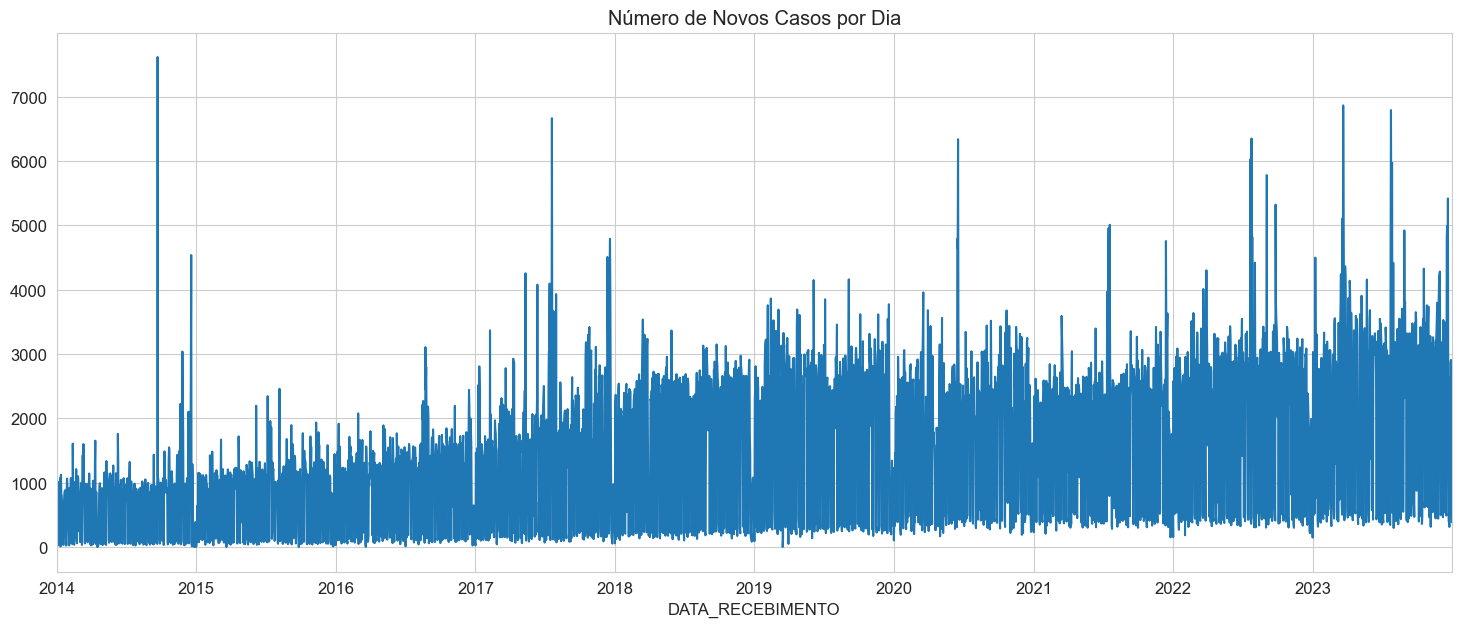

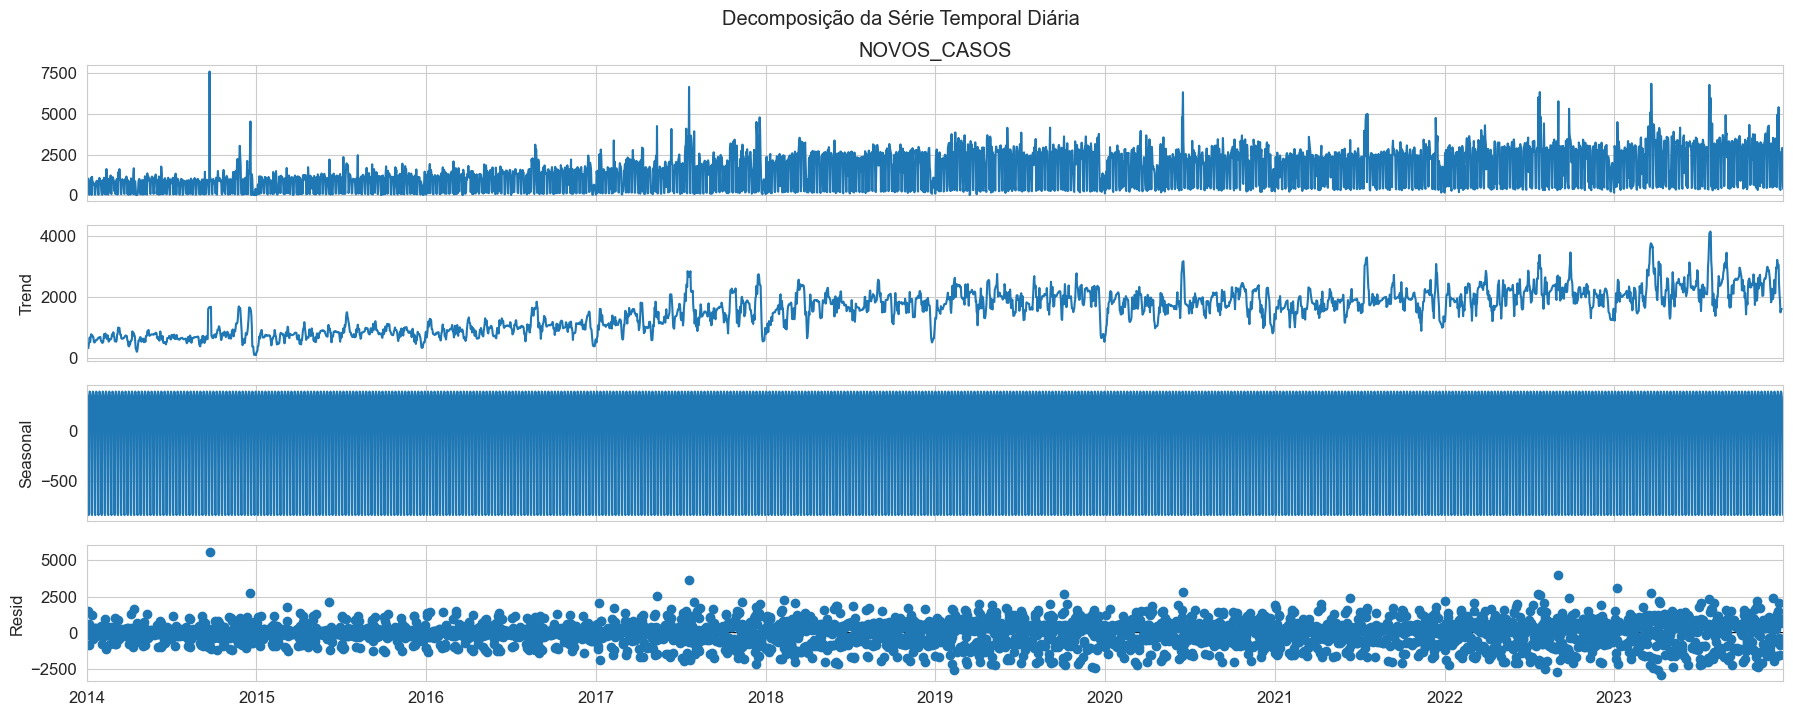

In [39]:
# --- 4.1. VISUALIZAÇÃO E DECOMPOSIÇÃO (DIÁRIA) ---

ts_df['NOVOS_CASOS'].plot(title='Número de Novos Casos por Dia')
plt.show()

decomposicao_diaria = seasonal_decompose(ts_df['NOVOS_CASOS'], model='additive', period=7)
fig = decomposicao_diaria.plot()
plt.suptitle('Decomposição da Série Temporal Diária', y=1.02)
plt.show()

--- Teste ADF na Série Original ---
p-valor: 0.015461122274108967
Conclusão: A série é ESTACIONÁRIA.

--- Gráficos de Autocorrelação (Série Original) ---


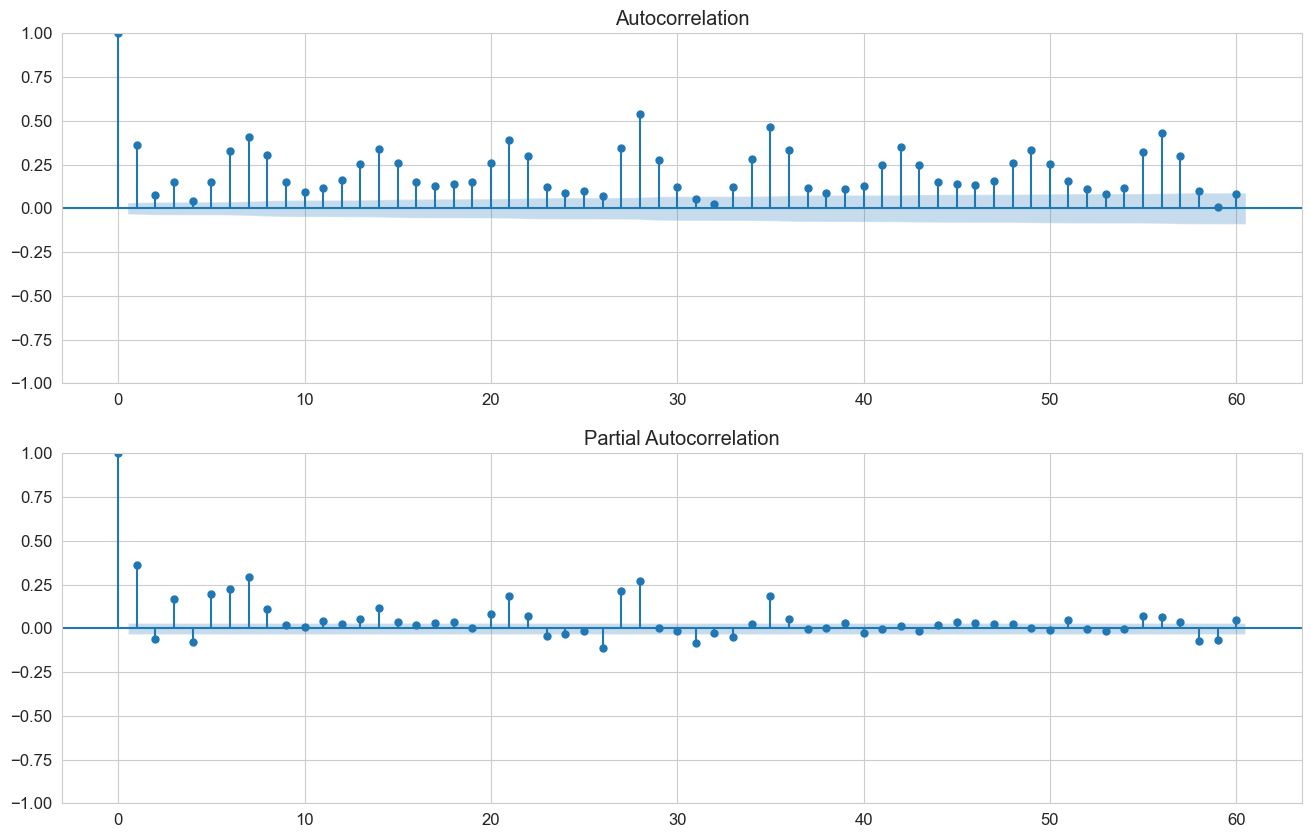

In [40]:
# --- 4.2. ANÁLISE DE ESTACIONARIEDADE E AUTOCORRELAÇÃO (SÉRIE ORIGINAL) ---

# Teste ADF na série original
print("--- Teste ADF na Série Original ---")
result_adf_orig = adfuller(ts_df['NOVOS_CASOS'])
print(f'p-valor: {result_adf_orig[1]}')
if result_adf_orig[1] > 0.05:
    print("Conclusão: A série é NÃO-ESTACIONÁRIA.")
else:
    print("Conclusão: A série é ESTACIONÁRIA.")

# Gráficos de Autocorrelação (ACF e PACF)
print("\n--- Gráficos de Autocorrelação (Série Original) ---")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
plot_acf(ts_df['NOVOS_CASOS'], ax=ax1, lags=60)
plot_pacf(ts_df['NOVOS_CASOS'], ax=ax2, lags=60)
plt.show()

--- Teste ADF na Série Diferenciada ---
p-valor: 0.0
Conclusão: A série diferenciada é agora ESTACIONÁRIA.


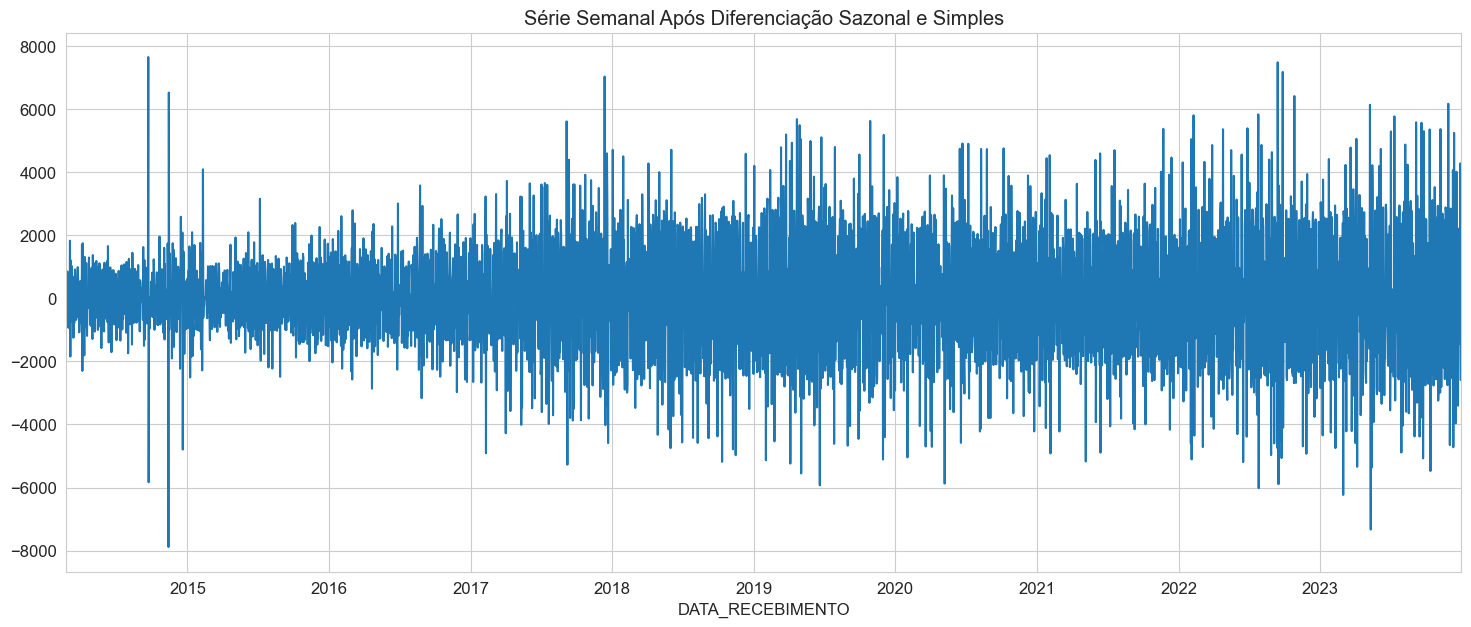

In [41]:
# --- 5.1. DIFERENCIAÇÃO E VERIFICAÇÃO ---

# Aplicando diferenciação sazonal (lag=52 para semanas) e simples (lag=1)
ts_df['casos_diff'] = ts_df['NOVOS_CASOS'].diff(52).diff()
ts_diff_final = ts_df['casos_diff'].dropna()

# Verificando a estacionariedade da série diferenciada
print("--- Teste ADF na Série Diferenciada ---")
result_adf_diff = adfuller(ts_diff_final)
print(f'p-valor: {result_adf_diff[1]}')
if result_adf_diff[1] <= 0.05:
    print("Conclusão: A série diferenciada é agora ESTACIONÁRIA.")
else:
    print("Conclusão: A série ainda NÃO é ESTACIONÁRIA. Pode ser necessário ajustar a diferenciação.")

# Visualizando a série diferenciada 
ts_diff_final.plot(title='Série Semanal Após Diferenciação Sazonal e Simples')
plt.show()


--- Gráficos de Autocorrelação (Série Diferenciada) ---


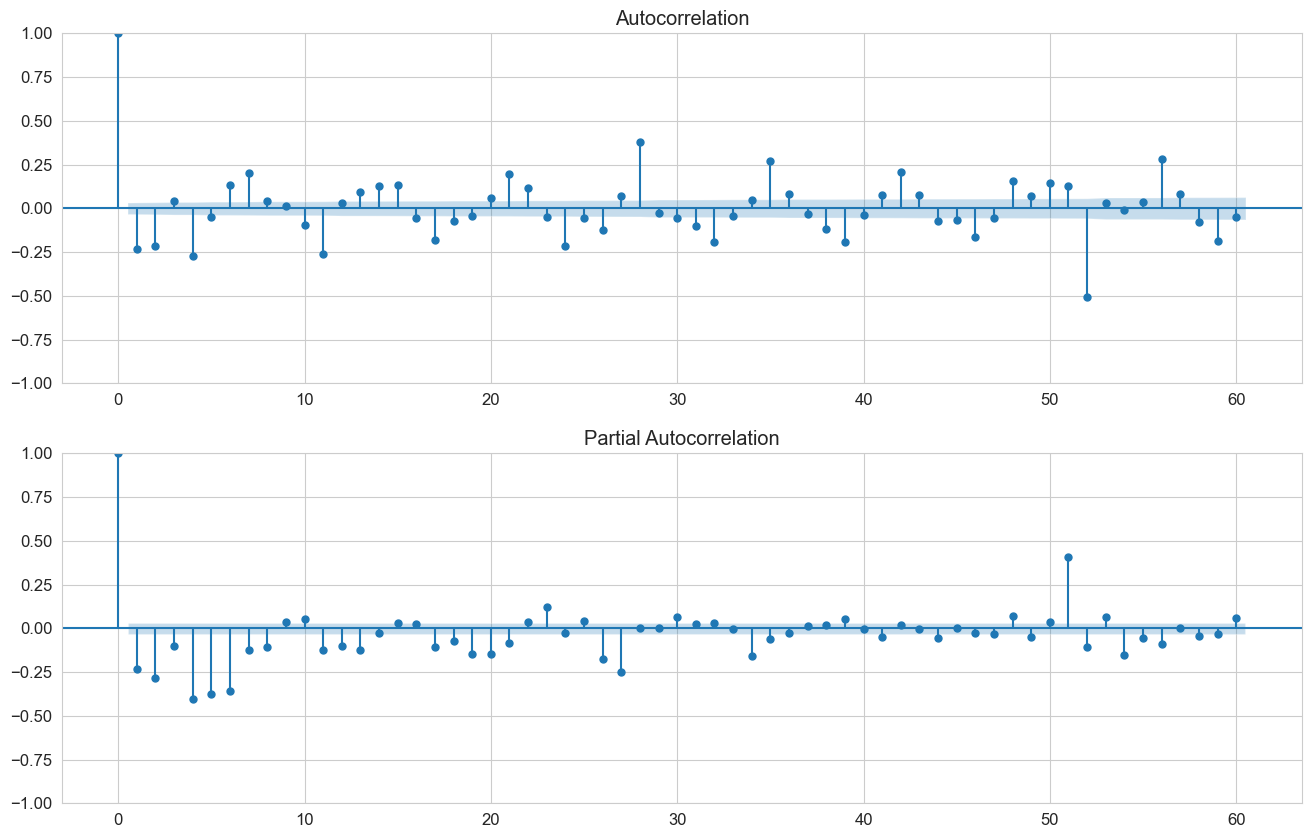

In [42]:
# --- 5.2. ANÁLISE DE AUTOCORRELAÇÃO (SÉRIE DIFERENCIADA) ---

print("\n--- Gráficos de Autocorrelação (Série Diferenciada) ---")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
plot_acf(ts_diff_final, ax=ax1, lags=60)
plot_pacf(ts_diff_final, ax=ax2, lags=60)
plt.show()

In [43]:
# --- 6.1. DIVISÃO DOS DADOS EM TREINO E TESTE ---

if 'ts_df' in locals() and isinstance(ts_df, pd.DataFrame) and not ts_df.empty:
    treino = ts_df.iloc[:-52]
    teste = ts_df.iloc[-52:]

    print("Divisão dos dados concluída:")
    print(f"Período de Treino: {treino.index.min().strftime('%Y-%m-%d')} a {treino.index.max().strftime('%Y-%m-%d')}")
    print(f"Período de Teste:  {teste.index.min().strftime('%Y-%m-%d')} a {teste.index.max().strftime('%Y-%m-%d')}")
else:
    print("ERRO: O DataFrame 'ts_df' não foi encontrado ou está vazio. Por favor, execute as células anteriores.")

Divisão dos dados concluída:
Período de Treino: 2014-01-01 a 2023-11-09
Período de Teste:  2023-11-10 a 2023-12-31


In [44]:
# --- 6.2. TREINAMENTO DO MODELO SARIMA ---

# Verificando se o conjunto de treino existe antes de prosseguir
if 'treino' in locals():
    print("Iniciando o treinamento do modelo SARIMA(0, 1, 1)x(1, 1, 1, 52)...")
    
    # Instanciando o modelo com os parâmetros definidos'
    modelo = SARIMAX(treino['NOVOS_CASOS'],
                     order=(0, 1, 1),
                     seasonal_order=(1, 1, 1, 52),
                     enforce_stationarity=False,
                     enforce_invertibility=False)

    resultado = modelo.fit(disp=False) 

    print("\n Treinamento concluído!")
    
    # Imprimindo um resumo dos resultados do modelo
    print(resultado.summary())
else:
    print("ERRO: O conjunto de treino 'treino' não foi encontrado.")

Iniciando o treinamento do modelo SARIMA(0, 1, 1)x(1, 1, 1, 52)...

 Treinamento concluído!
                                     SARIMAX Results                                      
Dep. Variable:                        NOVOS_CASOS   No. Observations:                 3600
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 52)   Log Likelihood              -29278.972
Date:                            Wed, 06 Aug 2025   AIC                          58565.944
Time:                                    15:05:10   BIC                          58590.578
Sample:                                01-01-2014   HQIC                         58574.736
                                     - 11-09-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0097 

Gerando gráficos de diagnóstico do modelo...


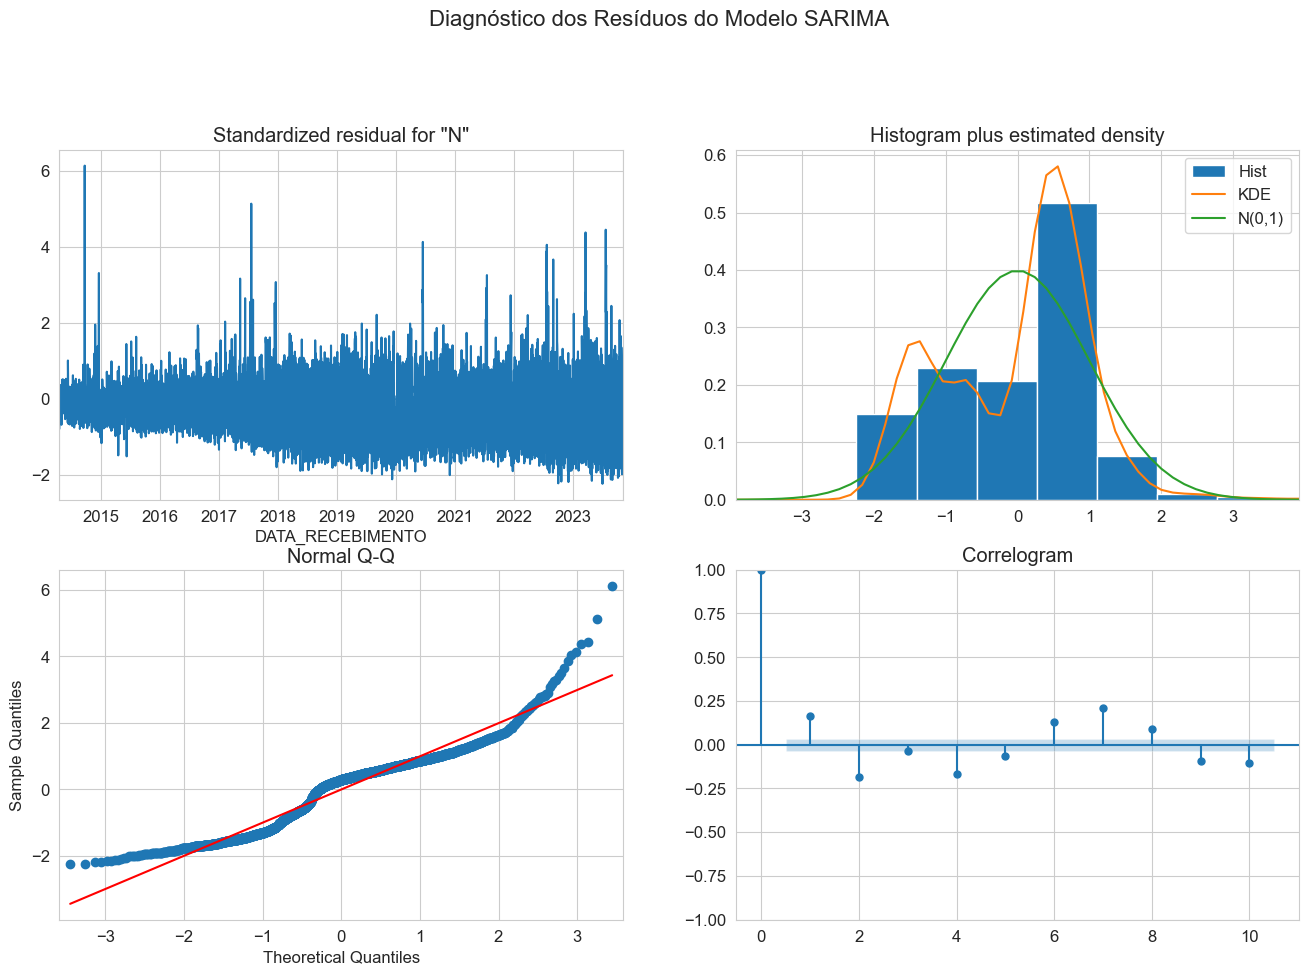

In [45]:
# --- 6.3. ANÁLISE DE DIAGNÓSTICO DO MODELO ---

if 'resultado' in locals():
    print("Gerando gráficos de diagnóstico do modelo...")
    resultado.plot_diagnostics(figsize=(16, 10))
    plt.suptitle("Diagnóstico dos Resíduos do Modelo SARIMA", y=1.02, fontsize=16)
    plt.show()
else:
    print("ERRO: O objeto 'resultado' do modelo não foi encontrado.")

Gerando previsões para o período de teste...


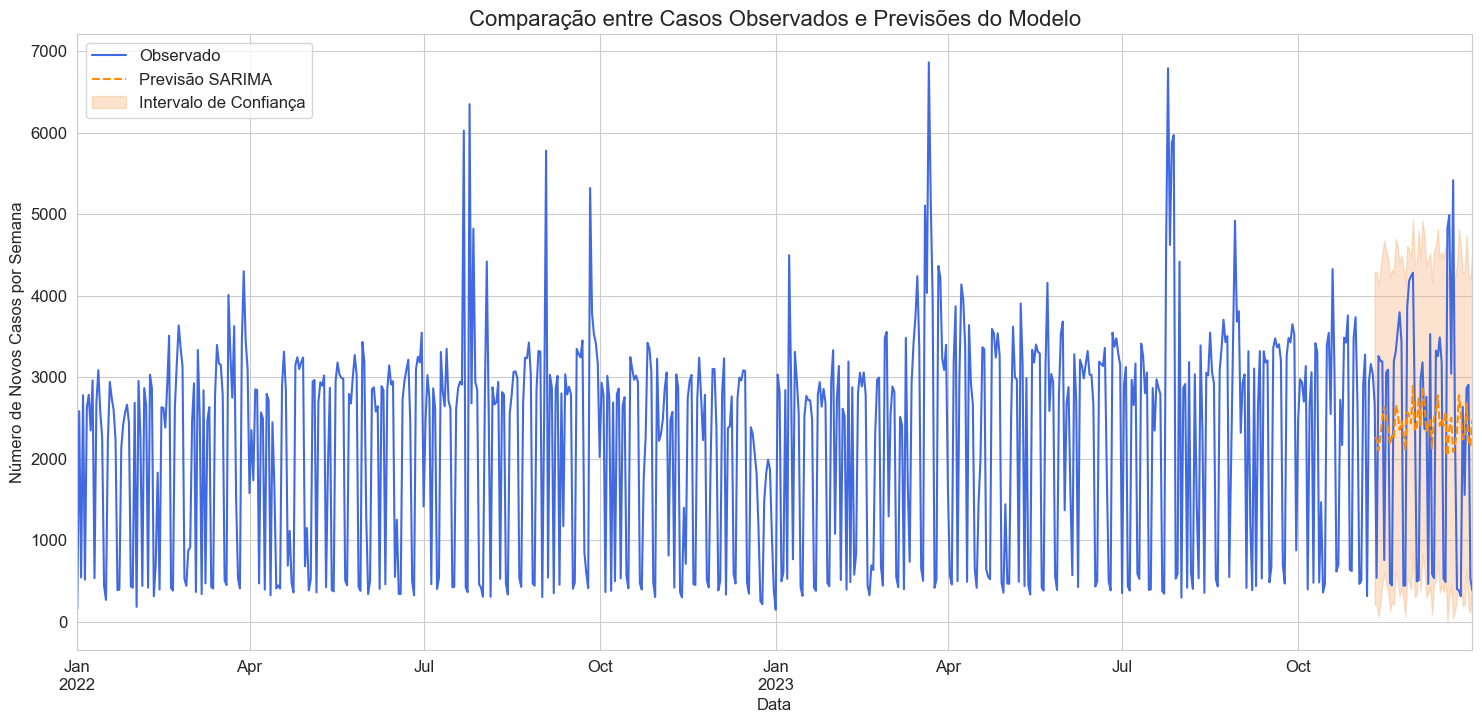

In [46]:
# --- 7. PREVISÃO E AVALIAÇÃO VISUAL ---

if 'resultado' in locals() and 'teste' in locals():
    print("Gerando previsões para o período de teste...")

    # Gerando as previsões para o período do conjunto de teste
    previsoes = resultado.get_prediction(start=teste.index[0], end=teste.index[-1])
    
    # Obtendo o intervalo de confiança das previsões
    pred_ci = previsoes.conf_int()

    # --- Visualização Comparativa ---
    plt.figure(figsize=(18, 8))
    
    # Plotando os dados observados (treino e teste)
    ax = ts_df['NOVOS_CASOS']['2022':].plot(label='Observado', color='royalblue')

    # Plotando as previsões
    previsoes.predicted_mean.plot(ax=ax, label='Previsão SARIMA', color='darkorange', style='--')

    # Plotando o intervalo de confiança
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='sandybrown', alpha=.3, label='Intervalo de Confiança')

    ax.set_title('Comparação entre Casos Observados e Previsões do Modelo', fontsize=16)
    ax.set_xlabel('Data')
    ax.set_ylabel('Número de Novos Casos por Semana')
    plt.legend(loc='upper left')
    plt.show()
else:
    print("ERRO: Certifique-se de que o modelo foi treinado ('resultado') e os dados de teste existem.")

In [49]:
from pmdarima import auto_arima

print("Iniciando a busca automática pelos melhores parâmetros SARIMA (diário)...")

auto_model_diario = auto_arima(ts_df['NOVOS_CASOS'],
                               start_p=0, start_q=0,
                               max_p=3, max_q=3,
                               d=1, D=1, m=7,  # m=7 para semanalidade em dados diários
                               seasonal=True,
                               trace=True,
                               error_action='ignore',
                               suppress_warnings=True,
                               stepwise=True)

print("\n--- Melhor Modelo Diário Encontrado ---")
print(auto_model_diario.summary())

best_order_diario = auto_model_diario.order
best_seasonal_order_diario = auto_model_diario.seasonal_order
print(f"\nOrdem SARIMA ótima (diário): {best_order_diario}")
print(f"Ordem Sazonal ótima (diário): {best_seasonal_order_diario}")


Iniciando a busca automática pelos melhores parâmetros SARIMA (diário)...
Performing stepwise search to minimize aic


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=1.52 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=64697.472, Time=0.06 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[7]             : AIC=63174.097, Time=1.37 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.88 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=64082.583, Time=0.13 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[7]             : AIC=62633.179, Time=3.47 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=5.11 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.10 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,0)[7]             : AIC=63156.438, Time=0.74 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[7]             : AIC=61872.595, Time=4.09 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[7]             : AIC=62388.255, Time=2.23 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=6.86 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=4.78 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,1,0)[7]             : AIC=61844.675, Time=5.66 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,1,0)[7]             : AIC=62362.157, Time=2.67 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,1,1)[7]             : AIC=inf, Time=8.91 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,1,1)[7]             : AIC=inf, Time=4.78 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,1,0)[7]             : AIC=inf, Time=9.93 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,1,0)[7]             : AIC=inf, Time=7.10 sec


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,1,0)[7] intercept   : AIC=61846.675, Time=6.56 sec

Best model:  ARIMA(3,1,0)(2,1,0)[7]          
Total fit time: 79.964 seconds

--- Melhor Modelo Diário Encontrado ---
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 3652
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -30916.338
Date:                           Wed, 06 Aug 2025   AIC                          61844.675
Time:                                   15:37:07   BIC                          61881.880
Sample:                               01-01-2014   HQIC                         61857.926
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

In [50]:
# --- IMPLEMENTAÇÃO DO BACKTESTING (ROLLING FORECAST) COM PARÂMETROS CORRIGIDOS ---

order = (3, 1, 0)
seasonal_order = (2, 1, 0, 7)

print(f"Usando ordem SARIMA manual: order={order}, seasonal_order={seasonal_order}")

# Preparando os dados 
X = ts_df['NOVOS_CASOS'].values
tamanho_treino = int(len(X) * 0.80)
treino, teste = X[0:tamanho_treino], X[tamanho_treino:len(X)]

historico = [x for x in treino]
previsoes = []

print(f"\nIniciando o processo de Rolling Forecast...")
print(f"Tamanho do treino inicial: {len(historico)}")
print(f"Número de previsões a serem feitas: {len(teste)}")

for t in range(len(teste)):
    # Instanciando e treinando o modelo com a ordem corrigida
    modelo = SARIMAX(historico, order=order, seasonal_order=seasonal_order,
                     enforce_stationarity=False, enforce_invertibility=False)
    
    modelo_fit = modelo.fit(disp=False)
    
    # Fazendo a previsão para um passo à frente
    output = modelo_fit.forecast()
    yhat = output[0]
    previsoes.append(yhat)
    
    # Adicionando o valor real observado ao histórico
    obs = teste[t]
    historico.append(obs)
    
    # Imprimindo o progresso
    if (t+1) % 10 == 0: # Imprime o progresso a cada 10 semanas
        print(f'Semana {t+1}/{len(teste)} | Previsto={yhat:.2f}, Observado={obs}')

print("\n✅ Processo de Backtesting concluído!")

Usando ordem SARIMA manual: order=(3, 1, 0), seasonal_order=(2, 1, 0, 7)

Iniciando o processo de Rolling Forecast...
Tamanho do treino inicial: 2921
Número de previsões a serem feitas: 731
Semana 10/731 | Previsto=2199.34, Observado=2961
Semana 20/731 | Previsto=1561.16, Observado=2744
Semana 30/731 | Previsto=1276.52, Observado=434
Semana 40/731 | Previsto=1902.47, Observado=3031
Semana 50/731 | Previsto=2034.57, Observado=3511
Semana 60/731 | Previsto=2083.91, Observado=874
Semana 70/731 | Previsto=1773.09, Observado=2474
Semana 80/731 | Previsto=909.63, Observado=451
Semana 90/731 | Previsto=2209.35, Observado=3447
Semana 100/731 | Previsto=243.24, Observado=394
Semana 110/731 | Previsto=1852.31, Observado=3315
Semana 120/731 | Previsto=2573.49, Observado=3242
Semana 130/731 | Previsto=2656.77, Observado=2895
Semana 140/731 | Previsto=3233.84, Observado=2992
Semana 150/731 | Previsto=1368.66, Observado=379
Semana 160/731 | Previsto=3295.48, Observado=403
Semana 170/731 | Previsto=9


--- Métricas de Erro do Backtesting ---
Mean Absolute Error (MAE): 1179.47
Root Mean Squared Error (RMSE): 1522.88


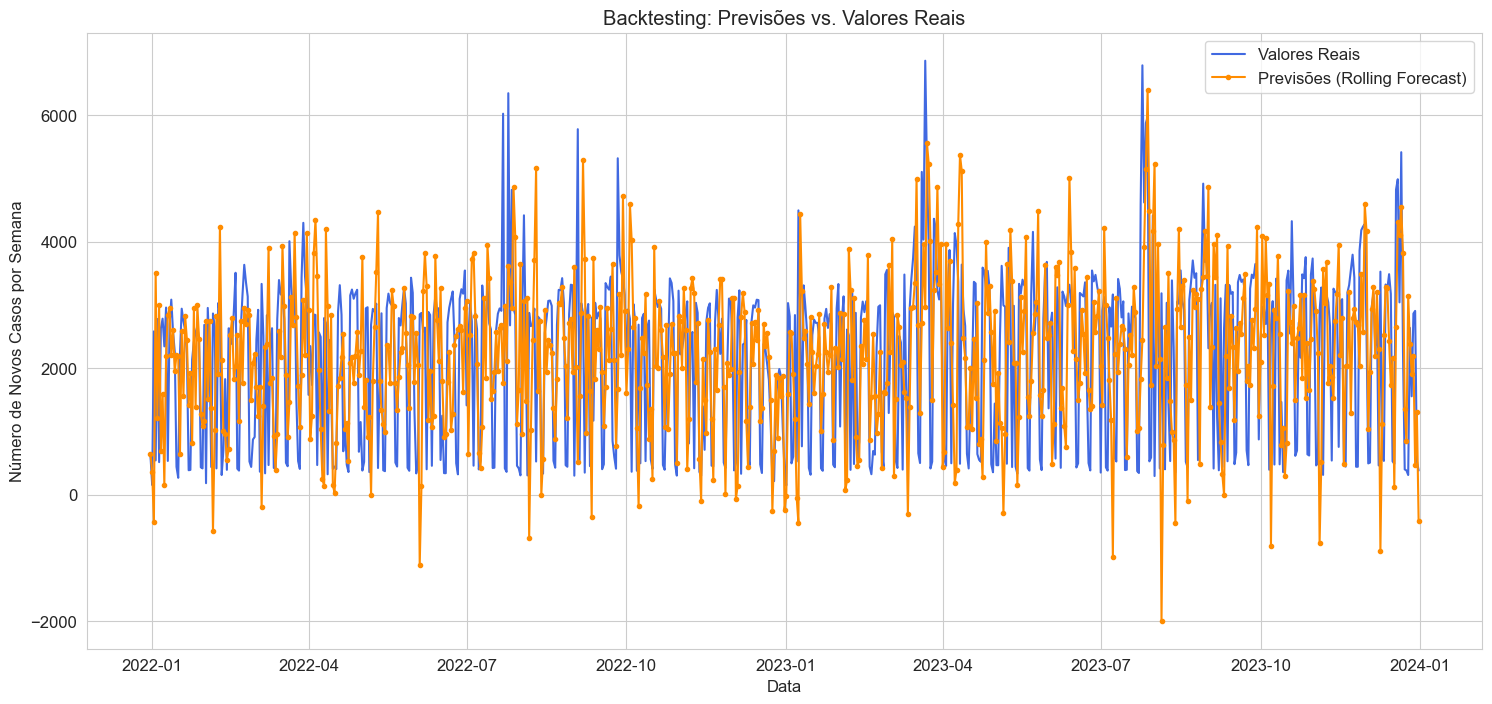

In [51]:
# --- AVALIAÇÃO DA PERFORMANCE DO BACKTESTING ---

# Calculando as métricas de erro
mae = mean_absolute_error(teste, previsoes)
rmse = np.sqrt(mean_squared_error(teste, previsoes))

print(f'\n--- Métricas de Erro do Backtesting ---')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Visualizando os resultados
plt.figure(figsize=(18, 8))
plt.plot(ts_df.index[-len(teste):], teste, color='royalblue', label='Valores Reais')
plt.plot(ts_df.index[-len(teste):], previsoes, color='darkorange', marker='.', label='Previsões (Rolling Forecast)')
plt.title('Backtesting: Previsões vs. Valores Reais')
plt.xlabel('Data')
plt.ylabel('Número de Novos Casos por Semana')
plt.legend()
plt.show()

Previsão de novos casos para as próximas 12 semanas:
2024-01-01    1664.492007
2024-01-02    3212.466634
2024-01-03    2316.243955
2024-01-04    3655.794710
2024-01-05    2734.990913
2024-01-06     337.853204
2024-01-07     303.371019
2024-01-08    2380.699470
2024-01-09    3589.851806
2024-01-10    2270.457651
2024-01-11    3986.699166
2024-01-12    2477.557606
2024-01-13     278.969714
2024-01-14     225.213255
2024-01-15    1325.436746
2024-01-16    3023.778152
2024-01-17    1892.959024
2024-01-18    3369.832212
2024-01-19    2568.919385
2024-01-20     258.645228
2024-01-21     174.398345
2024-01-22    1574.599741
2024-01-23    3100.740725
2024-01-24    2010.532799
2024-01-25    3494.550525
2024-01-26    2480.110988
2024-01-27     164.840403
2024-01-28     106.095785
2024-01-29    1681.987709
2024-01-30    3133.491701
2024-01-31    1949.761951
2024-02-01    3516.971017
2024-02-02    2372.822112
2024-02-03     101.409155
2024-02-04      38.378229
2024-02-05    1398.267294
2024-02-06 

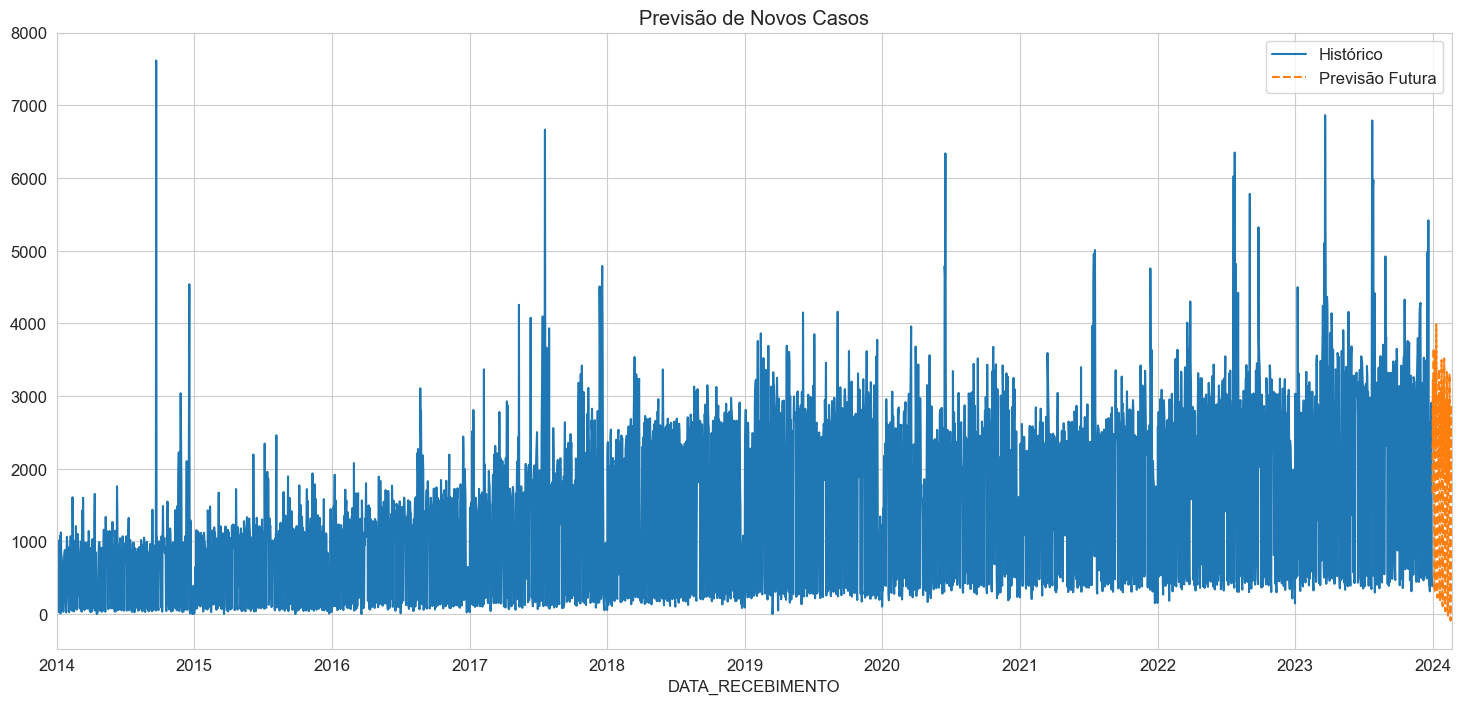

In [56]:
# --- PREVENDO O FUTURO ---

# 1. Treinando o modelo final com todos os dados
modelo_final = SARIMAX(ts_df['NOVOS_CASOS'], order=((3, 1, 0)), seasonal_order=(2, 1, 0, 7))
resultado_final = modelo_final.fit()

# 2. Prevendo as próximas 12 semanas
previsao_futuro = resultado_final.forecast(steps=52)

print("Previsão de novos casos para as próximas 12 semanas:")
print(previsao_futuro)

# Plotando o histórico e a previsão futura
plt.figure(figsize=(18, 8))
ts_df['NOVOS_CASOS'].plot(label='Histórico')
previsao_futuro.plot(label='Previsão Futura', style='--')
plt.legend()
plt.title('Previsão de Novos Casos')
plt.show()